<a href="https://colab.research.google.com/github/mobadata/detection-nouveautes-avis/blob/main/Detection_nouveautes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importons les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("punkt")
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [46]:
# Montons note Google drive dans le notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importation des donn√©es

# Chemin du fichier JSON dans le drive
chemin_fichier = "/content/drive/MyDrive/mon_projet_nouveautes/Electronics_5.json"

# Chargement du fichier (format JSON lignes si Amazon)
df = pd.read_json(chemin_fichier, lines=True)

# Affichage des premi√®res lignes
df.head()


reviewerID        asin              reviewerName   helpful  \
0   AO94DHGC771SJ  0528881469                   amazdnu    [0, 0]   
1   AMO214LNFCEI4  0528881469           Amazon Customer  [12, 15]   
2  A3N7T0DY83Y4IG  0528881469             C. A. Freeman  [43, 45]   
3  A1H8PY3QHMQQA0  0528881469  Dave M. Shaw "mack dave"   [9, 10]   
4  A24EV6RXELQZ63  0528881469               Wayne Smith    [0, 0]   

                                          reviewText  overall  \
0  We got this GPS for my husband who is an (OTR)...        5   
1  I'm a professional OTR truck driver, and I bou...        1   
2  Well, what can I say.  I've had this unit in m...        3   
3  Not going to write a long review, even thought...        2   
4  I've had mine for a year and here's what we go...        1   

                                  summary  unixReviewTime   reviewTime  
0                         Gotta have GPS!      1370131200   06 2, 2013  
1                       Very Disappointed      1290643200  11 25, 2010  
2                          1st impression      1283990400   09 9, 2010  
3                 Great grafics, POOR GPS      1290556800  11 24, 2010  
4  Major issues, only excuses for support      1317254400  09 29, 2011

In [ ]:

# infos sur les variables
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689188 entries, 0 to 1689187
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   reviewerID      1689188 non-null  object
 1   asin            1689188 non-null  object
 2   reviewerName    1664458 non-null  object
 3   helpful         1689188 non-null  object
 4   reviewText      1689188 non-null  object
 5   overall         1689188 non-null  int64 
 6   summary         1689188 non-null  object
 7   unixReviewTime  1689188 non-null  int64 
 8   reviewTime      1689188 non-null  object
dtypes: int64(2), object(7)
memory usage: 116.0+ MB


In [ ]:
# Apercu statistique des donn√©es
df.describe(include='all')


reviewerID        asin     reviewerName  helpful reviewText  \
count        1689188     1689188          1664458  1689188    1689188   
unique        192403       63001           162859     8331    1687169   
top     ADLVFFE4VBT8  B007WTAJTO  Amazon Customer   [0, 0]              
freq             431        4915            26961   963227       1071   
mean             NaN         NaN              NaN      NaN        NaN   
std              NaN         NaN              NaN      NaN        NaN   
min              NaN         NaN              NaN      NaN        NaN   
25%              NaN         NaN              NaN      NaN        NaN   
50%              NaN         NaN              NaN      NaN        NaN   
75%              NaN         NaN              NaN      NaN        NaN   
max              NaN         NaN              NaN      NaN        NaN   

             overall      summary  unixReviewTime  reviewTime  
count   1.689188e+06      1689188    1.689188e+06     1689188  
unique           NaN      1139738             NaN        5277  
top              NaN  Works great             NaN  01 7, 2014  
freq             NaN         6784             NaN        3051  
mean    4.222779e+00          NaN    1.340571e+09         NaN  
std     1.185632e+00          NaN    6.342451e+07         NaN  
min     1.000000e+00          NaN    9.292320e+08         NaN  
25%     4.000000e+00          NaN    1.318118e+09         NaN  
50%     5.000000e+00          NaN    1.360800e+09         NaN  
75%     5.000000e+00          NaN    1.385078e+09         NaN  
max     5.000000e+00          NaN    1.406074e+09         NaN

In [ ]:
df["reviewText"].head(10)


0    We got this GPS for my husband who is an (OTR)...
1    I'm a professional OTR truck driver, and I bou...
2    Well, what can I say.  I've had this unit in m...
3    Not going to write a long review, even thought...
4    I've had mine for a year and here's what we go...
5    I am using this with a Nook HD+. It works as d...
6    The cable is very wobbly and sometimes disconn...
7    This adaptor is real easy to setup and use rig...
8    This adapter easily connects my Nook HD 7&#34;...
9    This product really works great but I found th...
Name: reviewText, dtype: object

In [ ]:
# Nettoyage des donn√©es
stop_words = set(stopwords.words('english'))

def nettoyer_texte(texte):
    if isinstance(texte, str):
        texte = texte.lower()  # Met en minuscule
        texte = re.sub(r"[^a-z\s]", "", texte)  # Supprime les caract√®res non alphab√©tiques
        tokens = word_tokenize(texte)  # Tokenisation
        mots_utiles = [mot for mot in tokens if mot not in stop_words]  # Supprime les stopwords
        return " ".join(mots_utiles)
    else:
        return ""

In [ ]:
# On applique la fonction sur la variable reviewText
df["review_clean"] = df["reviewText"].apply(nettoyer_texte)
df[["reviewText", "review_clean"]].head()

reviewText  \
0  We got this GPS for my husband who is an (OTR)...   
1  I'm a professional OTR truck driver, and I bou...   
2  Well, what can I say.  I've had this unit in m...   
3  Not going to write a long review, even thought...   
4  I've had mine for a year and here's what we go...   

                                        review_clean  
0  got gps husband otr road trucker impressed shi...  
1  im professional otr truck driver bought tnd tr...  
2  well say ive unit truck four days prior garmin...  
3  going write long review even thought unit dese...  
4  ive mine year heres got tries route non truck ...

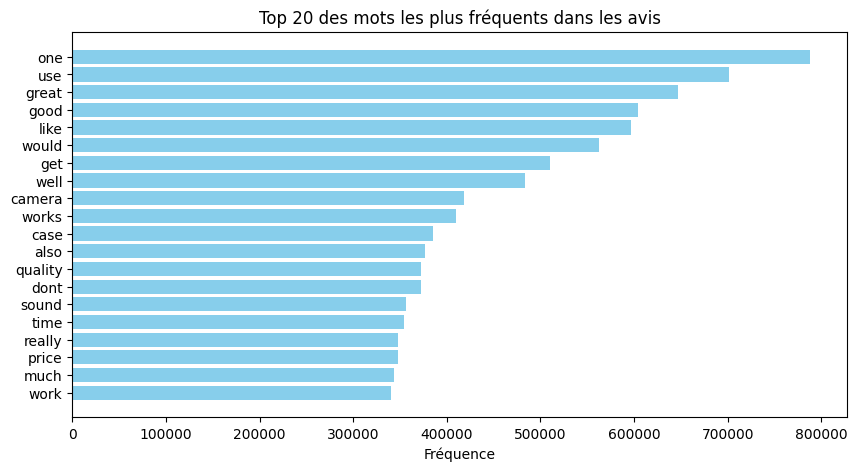

In [ ]:

# R√©cup√©rer tous les mots des textes nettoy√©s
tous_les_mots = " ".join(df["review_clean"]).split()

# Compter la fr√©quence des mots
freq = Counter(tous_les_mots)

# Top 20
top_mots = freq.most_common(20)
mots, counts = zip(*top_mots)

# Affichage
plt.figure(figsize=(10, 5))
plt.barh(mots, counts, color="skyblue")
plt.gca().invert_yaxis()
plt.title("Top 20 des mots les plus fr√©quents dans les avis")
plt.xlabel("Fr√©quence")
plt.show()


In [ ]:
!pip install bertopic umap-learn hdbscan sentence-transformers


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 150.6/150.6 kB 6.1 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.8/13.8 MB 15.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.6/24.6 MB 12.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 883.7/883.7 kB 19.1 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 664.8/664.8 MB 845.9 kB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

In [ ]:
# √©chantillon de 10000 avis pour tester
df_sample = df.sample(n=10000, random_state=42)

In [ ]:
# Cr√©ation et ajustement du mod√®le BERTopic
from bertopic import BERTopic
topic_model = BERTopic(language="english")
topics, probs = topic_model.fit_transform(df_sample["review_clean"])


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
topic_model.get_topic_info().head(10)  # Affiche les 10 th√®mes les plus fr√©quents


Topic  Count                             Name  \
0     -1   2934         -1_cable_one_works_great   
1      0    513      0_headphones_ear_sound_ears   
2      1    469       1_product_item_price_works   
3      2    289   2_camera_pictures_cameras_zoom   
4      3    264       3_card_reader_cards_memory   
5      4    200  4_protector_screen_bubbles_dust   
6      5    194        5_mouse_scroll_wheel_mice   
7      6    178   6_speakers_sub_subwoofer_sound   
8      7    161           7_lens_mm_focus_lenses   
9      8    161       8_keyboard_keys_key_typing   

                                      Representation  \
0  [cable, one, works, great, use, usb, drive, so...   
1  [headphones, ear, sound, ears, headset, bass, ...   
2  [product, item, price, works, great, good, bou...   
3  [camera, pictures, cameras, zoom, video, shoot...   
4  [card, reader, cards, memory, sandisk, sd, gb,...   
5  [protector, screen, bubbles, dust, film, prote...   
6  [mouse, scroll, wheel, mice, logitech, click, ...   
7  [speakers, sub, subwoofer, sound, bass, amp, s...   
8  [lens, mm, focus, lenses, sharp, tamron, sigma...   
9  [keyboard, keys, key, typing, keyboards, mouse...   

                                 Representative_Docs  
0  [upgraded iphone january already owned ipod to...  
1  [read review probably remember much gushing vm...  
2  [excellent product better expected great quali...  
3  [owned nikone many years served well course sh...  
4  [purchased make easier transfer pictures sd ca...  
5  [others commented unless youre hospital surger...  
6  [good little mouse laptop, mouse works great p...  
7  [quick take like design need desktop speaker s...  
8  [want one lens carry sigma mm lens nikon camer...  
9  [bought replace wireless keyboard problems usi...

In [ ]:
topic_model.get_topic(1)


[('product', np.float64(0.021037045452008688)),
 ('item', np.float64(0.018966993513853083)),
 ('price', np.float64(0.017071306425188476)),
 ('works', np.float64(0.015677815137177985)),
 ('great', np.float64(0.013976709020351648)),
 ('good', np.float64(0.013552662016416474)),
 ('bought', np.float64(0.012825515531053622)),
 ('working', np.float64(0.012018033947736631)),
 ('buy', np.float64(0.011700512598400877)),
 ('time', np.float64(0.010711108707026644))]

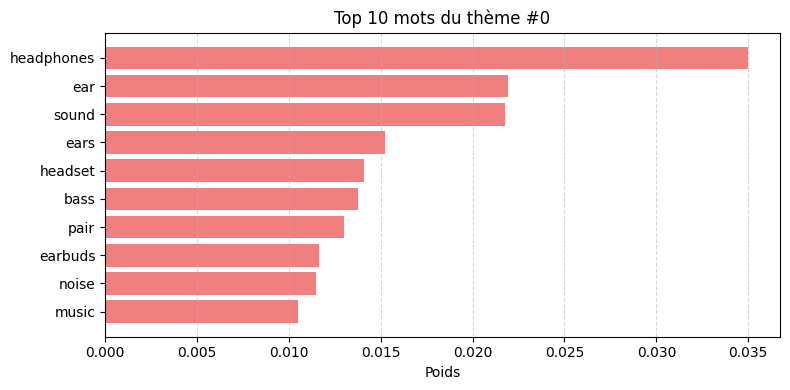

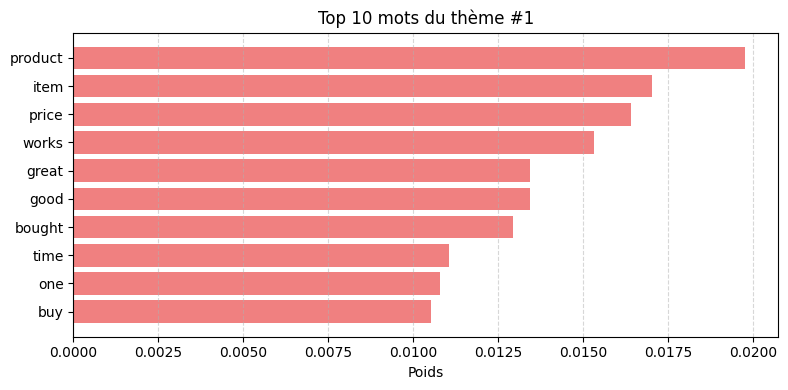

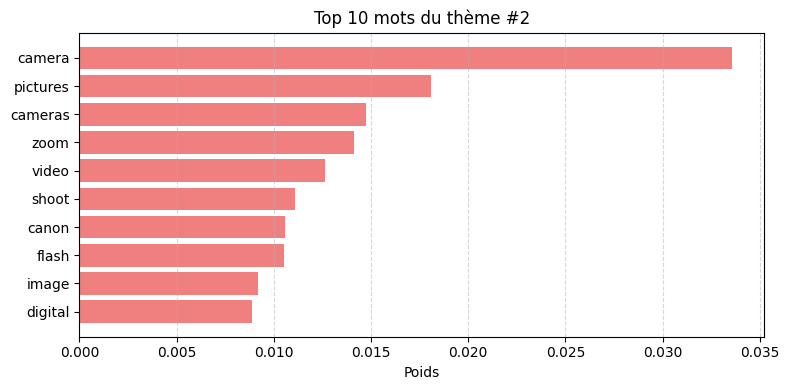

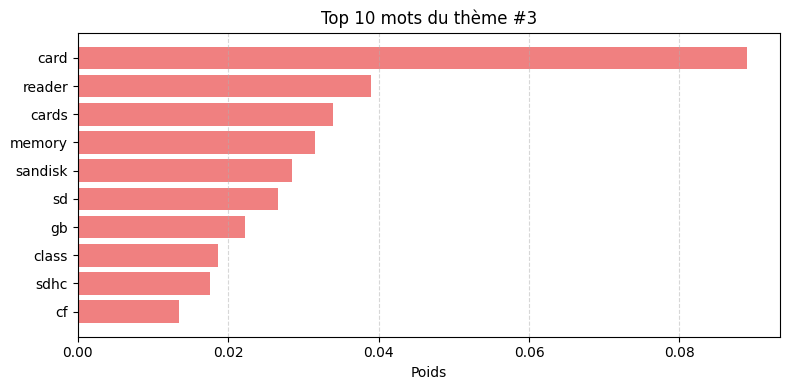

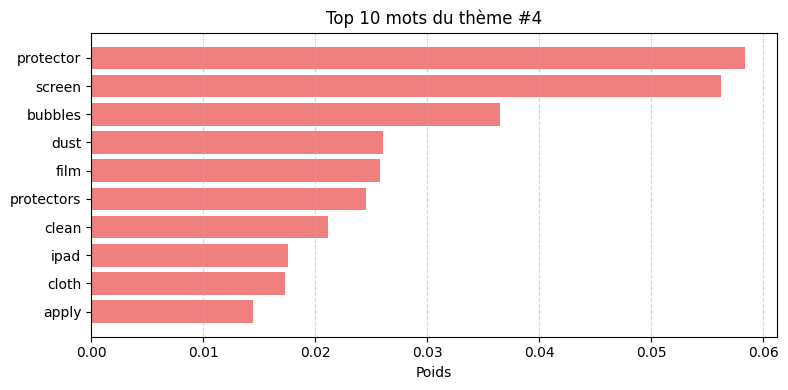

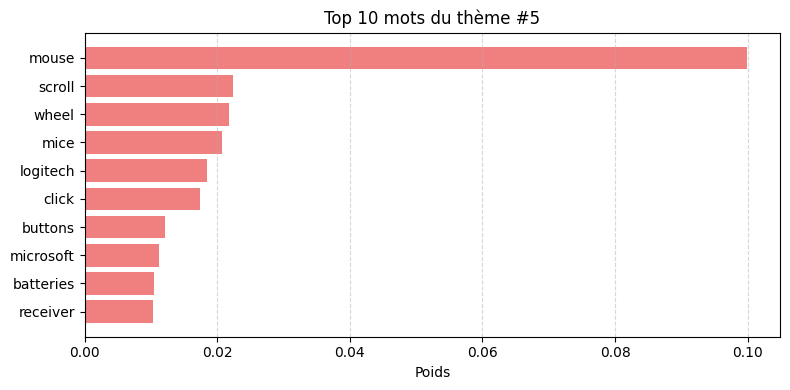

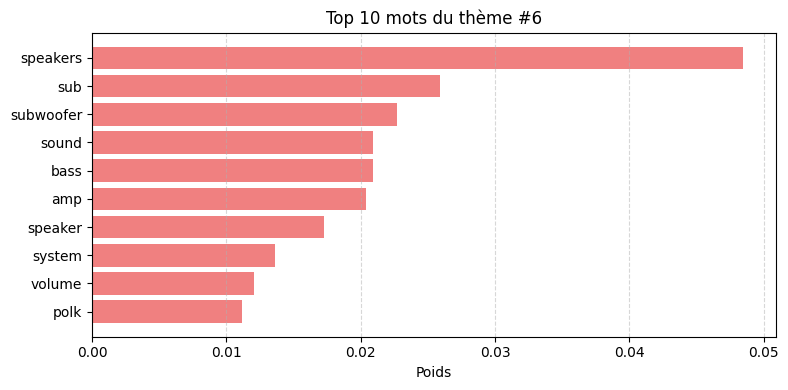

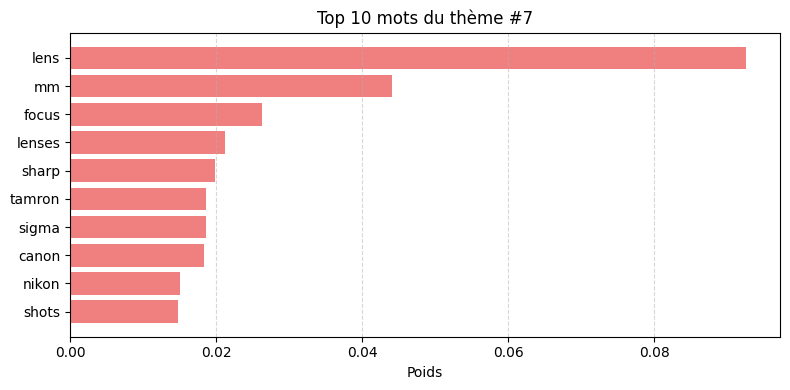

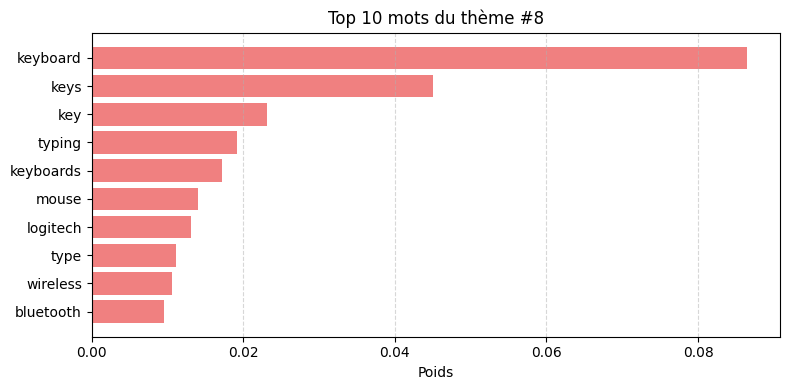

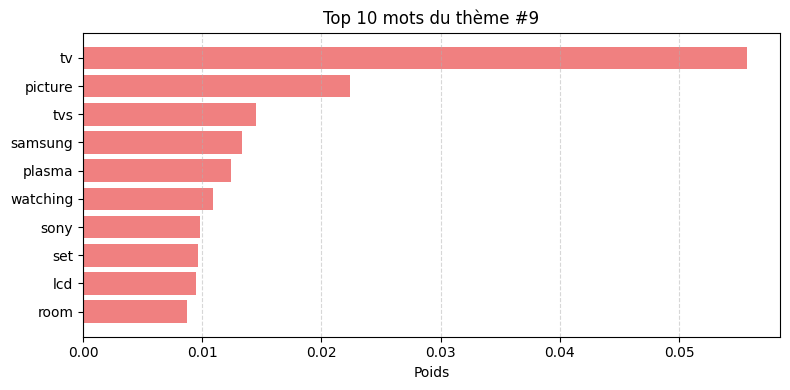

In [ ]:
for i in range(10):  # Afficher les 10 premiers topics
    topic_keywords = topic_model.get_topic(i)
    mots = [mot for mot, _ in topic_keywords]
    scores = [score for _, score in topic_keywords]

    plt.figure(figsize=(8, 4))
    plt.barh(mots[:10][::-1], scores[:10][::-1], color="lightcoral")
    plt.xlabel("Poids")
    plt.title(f"Top 10 mots du th√®me #{i}")
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
# Visualisation interactive des th√®mes
topic_model.visualize_topics()


In [ ]:
df_sample["reviewTime"] = pd.to_datetime(df_sample["reviewTime"])


In [ ]:
df_sample = df_sample.reset_index(drop=True)

In [ ]:
topics_over_time = topic_model.topics_over_time(
    docs=df_sample["review_clean"],
    topics=topics,
    timestamps=df_sample["reviewTime"],
    nr_bins=20,         # nombre de p√©riodes (tu peux l‚Äôajuster)
    evolution_tuning=True
)


In [ ]:
topic_model.visualize_topics_over_time(topics_over_time)


In [ ]:
df_sample["topic"] = topics
df_sample["probability"] = probs

In [ ]:
df_sample["month"] = df_sample["reviewTime"].dt.to_period("M")
# Filtrer les avis r√©cents (dernier mois)
latest_month = df_sample["month"].max()
recent_topics = df_sample[df_sample["month"] == latest_month]["topic"].value_counts()

# Filtrer les avis anciens (6 mois avant)
old_month = latest_month - 6
old_topics = df_sample[df_sample["month"] == old_month]["topic"].value_counts()

# Comparer les tendances
new_topics = set(recent_topics.index) - set(old_topics.index)
print(f"üÜï Nouveaux th√®mes apparus ce mois-ci : {new_topics}")


üÜï Nouveaux th√®mes apparus ce mois-ci : {96, 33, 98, 102, 106, 43, 107, 82, 55}


In [ ]:
for topic_id in [96, 33, 98, 102, 106, 43, 107, 82, 55]:
    print(f"\nTopic {topic_id}:")
    print(topic_model.get_topic(topic_id))



Topic 96:
[('hdmi', np.float64(0.06926600345594817)), ('switcher', np.float64(0.06115599641592105)), ('switch', np.float64(0.05362826051072307)), ('switching', np.float64(0.03513050883479065)), ('remote', np.float64(0.03007844966979749)), ('input', np.float64(0.028840588100158496)), ('connected', np.float64(0.02704349770090809)), ('automatically', np.float64(0.02551713636373558)), ('inputs', np.float64(0.024455101169517865)), ('tv', np.float64(0.023776807368534134))]

Topic 33:
[('router', np.float64(0.04743648523028113)), ('signal', np.float64(0.03482564539448374)), ('wireless', np.float64(0.0343529379777246)), ('house', np.float64(0.023338666447143785)), ('wifi', np.float64(0.02249636089538811)), ('repeater', np.float64(0.018104875574068355)), ('range', np.float64(0.014750862942781565)), ('internet', np.float64(0.014405327118457864)), ('network', np.float64(0.014201159693847457)), ('strength', np.float64(0.013149736663871757))]

Topic 98:
[('ya', np.float64(0.9709078095034261)), ('a

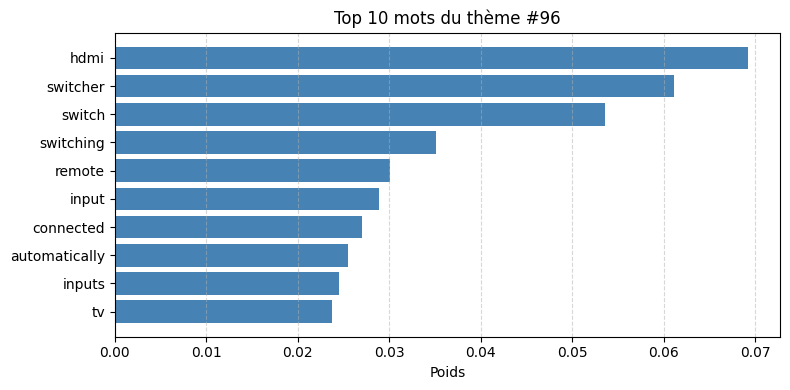

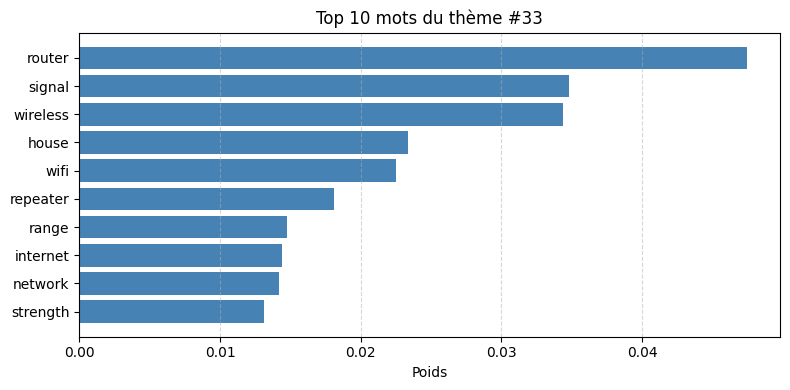

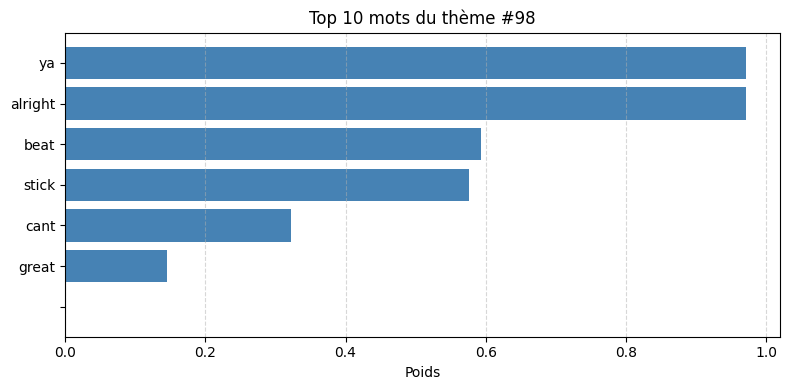

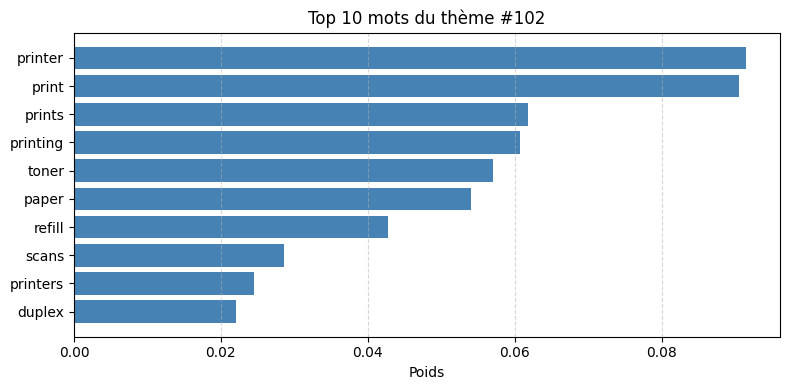

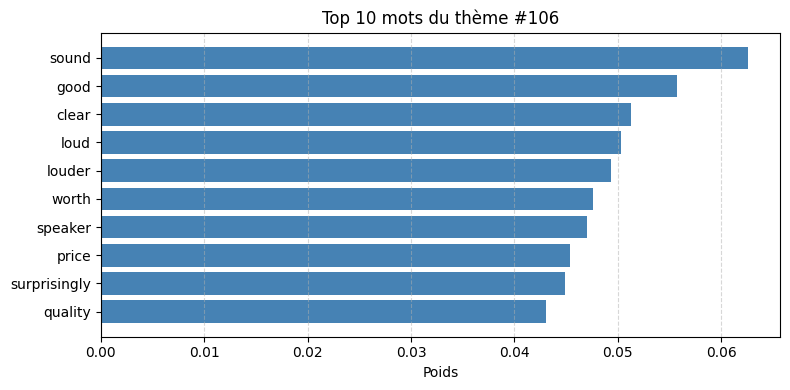

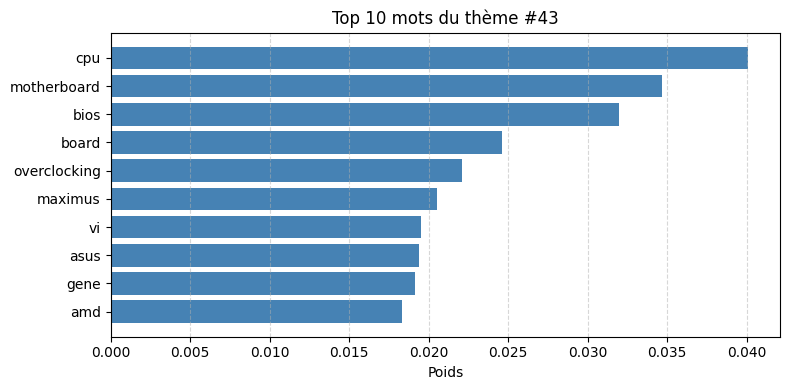

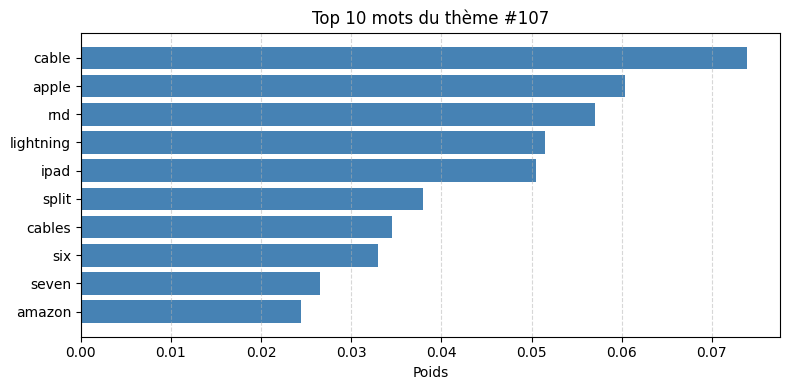

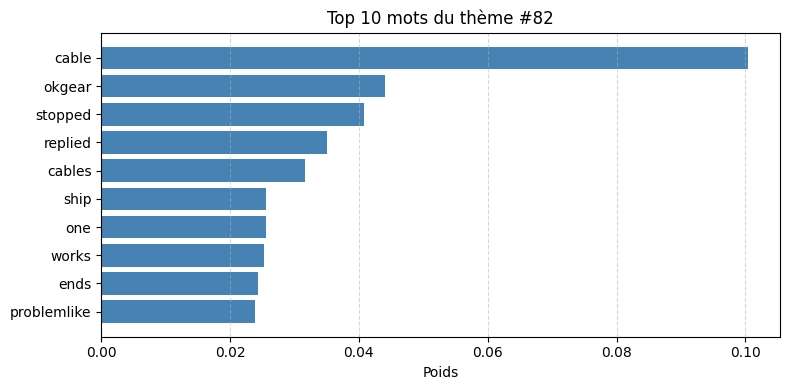

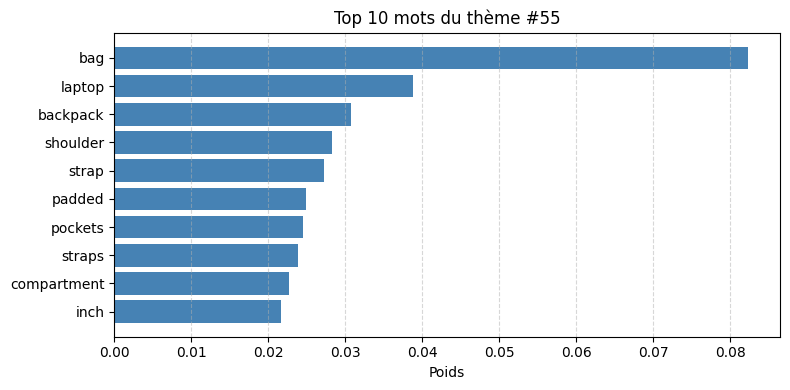

In [ ]:
for topic_id in new_topics:
    # R√©cup√©rer les mots et leurs poids
    topic_words = topic_model.get_topic(topic_id)
    if topic_words:  # v√©rifie que le topic n'est pas vide
        mots = [mot for mot, _ in topic_words][:10]
        scores = [score for _, score in topic_words][:10]

        # Graphique
        plt.figure(figsize=(8, 4))
        plt.barh(mots[::-1], scores[::-1], color="steelblue")
        plt.xlabel("Poids")
        plt.title(f"Top 10 mots du th√®me #{topic_id}")
        plt.grid(axis="x", linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Topic {topic_id} est vide.")


In [ ]:
for topic_id in [96, 33, 98, 102, 106, 43, 107, 82, 55]:
    print(f"\nExemples pour Topic {topic_id}:\n")
    docs = df[df["topic"] == topic_id]["review"].head(3).tolist()
    for doc in docs:
        print("-", doc)


In [ ]:
!pip install -q textblob
from textblob import TextBlob

In [ ]:
from textblob import TextBlob

df_sample["sentiment"] = df_sample["review_clean"].apply(lambda x: TextBlob(x).sentiment.polarity)


In [ ]:
# Calcul de la moyenne des sentiments par topic
sentiments_nouveaux_topics = df_sample[df_sample["topic"].isin(new_topics)] \
    .groupby("topic")["sentiment"] \
    .mean() \
    .reset_index(name="sentiment_moyen") \
    .sort_values(by="sentiment_moyen")

sentiments_nouveaux_topics

topic  sentiment_moyen
5     98         0.072727
4     96         0.153426
8    107         0.164546
0     33         0.176791
3     82         0.233818
2     55         0.235264
1     43         0.264487
6    102         0.272606
7    106         0.308855

In [ ]:
def sentiment_label(score):
    if score > 0.1:
        return "positif üü¢"
    elif score < -0.1:
        return "n√©gatif üî¥"
    else:
        return "neutre üü°"

sentiments_nouveaux_topics["tonalit√©"] = sentiments_nouveaux_topics["sentiment_moyen"].apply(sentiment_label)
sentiments_nouveaux_topics


topic  sentiment_moyen   tonalit√©
5     98         0.072727   neutre üü°
4     96         0.153426  positif üü¢
8    107         0.164546  positif üü¢
0     33         0.176791  positif üü¢
3     82         0.233818  positif üü¢
2     55         0.235264  positif üü¢
1     43         0.264487  positif üü¢
6    102         0.272606  positif üü¢
7    106         0.308855  positif üü¢

In [ ]:
df_sample[df_sample["topic"] == 82][["reviewText", "sentiment"]].sample(5)


reviewText  sentiment
6545  This cable works fine, my only complaint is th...   0.137500
9464  bad part, the cable i received was defective a...   0.179167
862   I'm giving this cable a 4 star rating because ...   0.172000
1264  This connector cable had the correct ends for ...   0.000000
215   What more can be said about a cable.It works. ...  -0.050000